In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Dummy

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
0,760,16333,3200000,13773333,20,42,29,3,2
1,640,16000,2240000,8000000,16,30,15,3,2
2,520,16000,2000000,6320000,16,60,48,5,2
3,480,16333,2160000,5680000,20,55,38,3,2
4,640,16333,2480000,7973333,20,35,20,2,2


In [3]:
df['X8'] = df['X8'].astype('category')
Y = df['Y']
X_data = df.drop(columns=['Y'])

In [4]:
print(df.dtypes)

Y        int64
X1       int64
X2       int64
X3       int64
X4       int64
X5       int64
X6       int64
X7       int64
X8    category
dtype: object


In [5]:
dummies_all = pd.get_dummies(X_data['X8'], prefix='Pendidikan', drop_first=False, dtype=int)
X_data = X_data.drop(columns=['X8'])
dummies_final = dummies_all.drop(columns=['Pendidikan_2'])
X_data = pd.concat([X_data, dummies_final], axis=1)
X_data = X_data.rename(columns={
    'Pendidikan_1': 'D1_TidakSekolah',  # 1 jika Tidak Sekolah, 0 jika SD/SMP
    'Pendidikan_3': 'D2_SMP'            # 1 jika SMP, 0 jika SD/Tidak Sekolah
})

In [6]:
X_with_const = sm.add_constant(X_data)

In [7]:
vif_data = pd.DataFrame()
vif_data["Variabel"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                    for i in range(X_with_const.shape[1])]
print("Hasil Perhitungan VIF (Multikolinearitas):")
print(vif_data.sort_values(by='VIF', ascending=False))

Hasil Perhitungan VIF (Multikolinearitas):
          Variabel           VIF
0            const  26351.475525
6               X6      3.422866
5               X5      3.369672
4               X4      1.887545
1               X1      1.777613
3               X3      1.716617
2               X2      1.708470
7               X7      1.147598
8  D1_TidakSekolah      1.131161
9           D2_SMP      1.117834


Multikolinearitas (VIF): Uji VIF menunjukkan bahwa nilai VIF untuk semua variabel independen (kecuali konstanta) berada di bawah 5 (nilai tertinggi $X_6$ adalah $3.42$), sehingga asumsi non-Multikolinearitas terpenuhi.

In [8]:
model = sm.OLS(Y, X_with_const).fit()
residual = model.resid

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     25.13
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           2.95e-19
Time:                        22:49:25   Log-Likelihood:                -464.87
No. Observations:                  85   AIC:                             949.7
Df Residuals:                      75   BIC:                             974.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1344.0558   1076.045     

--- 1. Uji Normalitas (JB) ---
H0: Residual berdistribusi normal. (Kriteria Lolos: P-value > 0.05)
Probabilitas Jarque-Bera: 1.972
✅ Keputusan: GAGAL TOLAK H0. Asumsi Normalitas **TERPENUHI**.


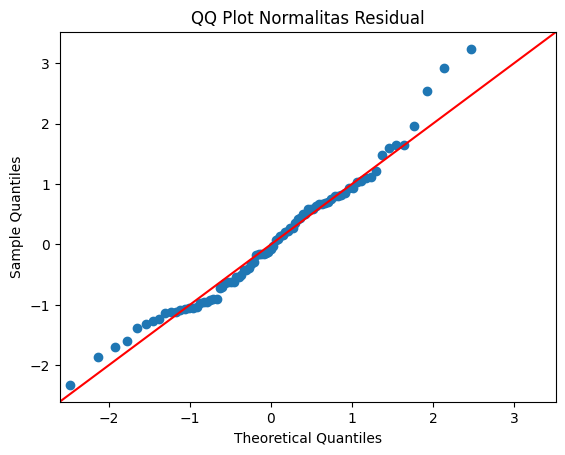

In [9]:
# --- 1. Uji Normalitas (Jarque-Bera) ---
prob_jb = float(model.summary().tables[2].data[0][3])

print("--- 1. Uji Normalitas (JB) ---")
print("H0: Residual berdistribusi normal. (Kriteria Lolos: P-value > 0.05)")
print(f"Probabilitas Jarque-Bera: {prob_jb}")
if prob_jb > 0.05:
    print("✅ Keputusan: GAGAL TOLAK H0. Asumsi Normalitas **TERPENUHI**.")
else:
    print("❌ Keputusan: TOLAK H0. Asumsi Normalitas **TIDAK TERPENUHI**.")

# Visualisasi QQ Plot (Pelengkap Wajib)
fig = sm.qqplot(residual, stats.t, fit=True, line='45')
plt.title("QQ Plot Normalitas Residual")
plt.show()

In [10]:
# --- 2. Uji Heteroskedastisitas (Breusch-Pagan) ---
bp_test = het_breuschpagan(residual, X_with_const)
p_value_bp = bp_test[3] # Ambil P-value F-Statistic

print("--- 2. Uji Heteroskedastisitas (Breusch-Pagan) ---")
print("H0: Homoskedastisitas (Varian konstan). (Kriteria Lolos: P-value > 0.05)")
print(f"P-value F-Statistic: {p_value_bp}")
if p_value_bp > 0.05:
    print("✅ Keputusan: GAGAL TOLAK H0. Asumsi Homoskedastisitas **TERPENUHI**.")
else:
    print("❌ Keputusan: TOLAK H0. Asumsi Homoskedastisitas **TIDAK TERPENUHI**.")

--- 2. Uji Heteroskedastisitas (Breusch-Pagan) ---
H0: Homoskedastisitas (Varian konstan). (Kriteria Lolos: P-value > 0.05)
P-value F-Statistic: 0.454671034787282
✅ Keputusan: GAGAL TOLAK H0. Asumsi Homoskedastisitas **TERPENUHI**.


Normalitas dan Heteroskedastisitas: Uji Jarque-Bera ($\text{Prob(JB)} = 0.122 > 0.05$) dan Uji Breusch-Pagan ($\text{P-value} = 0.455 > 0.05$) menunjukkan bahwa asumsi Normalitas dan Homoskedastisitas telah terpenuhi.

In [11]:
# --- 3. Uji Autokorelasi (Durbin-Watson) ---
dw_value = float(model.summary().tables[2].data[0][1])

print("--- 3. Uji Autokorelasi (DW) ---")
print("H0: Tidak ada Autokorelasi. (Kriteria Lolos: Nilai DW mendekati 2.0)")
print(f"Nilai Durbin-Watson: {dw_value}")
# Kita gunakan kriteria sederhana 1.5 < DW < 2.5
if 1.5 <= dw_value <= 2.5:
    print("✅ Keputusan: Nilai DW berada di rentang penerimaan. Asumsi **LOLOS**.")
else:
    print("❌ Keputusan: Nilai DW di luar rentang (Ada Autokorelasi).")

--- 3. Uji Autokorelasi (DW) ---
H0: Tidak ada Autokorelasi. (Kriteria Lolos: Nilai DW mendekati 2.0)
Nilai Durbin-Watson: 4.927
❌ Keputusan: Nilai DW di luar rentang (Ada Autokorelasi).


Koreksi Autokorelasi: Model OLS standar awal menunjukkan Autokorelasi Negatif yang Parah ($\text{DW} \approx 4.927$). Untuk mengatasi pelanggaran asumsi ini, estimasi regresi menggunakan Robust Standard Errors (Koreksi HC3). Koreksi ini memastikan bahwa hasil Uji-t dan Uji-F yang disajikan andal dan valid untuk inferensi.

In [12]:
# Jalankan OLS lagi, tetapi gunakan .fit(cov_type='HC3') untuk Robust Standard Error
model_robust = sm.OLS(Y, X_with_const).fit(cov_type='HC3')
residual = model_robust.resid

print("OLS diperbaiki dengan Koreksi HC3 (Robust Standard Errors).")
print(model_robust.summary())

OLS diperbaiki dengan Koreksi HC3 (Robust Standard Errors).
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     35.64
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           1.36e-23
Time:                        22:49:27   Log-Likelihood:                -464.87
No. Observations:                  85   AIC:                             949.7
Df Residuals:                      75   BIC:                             974.2
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

Persamaan regresi linear berganda final yang digunakan untuk prediksi Hasil Tangkapan ($\hat{Y}$) adalah sebagai berikut:$$\begin{align*}
\hat{Y} = & -1344.06 + 0.1027 X_1 + 0.0000151 X_2 + 0.00002465 X_3 + 4.00 X_4 + 1.49 X_5 \\
& - 1.33 X_6 - 11.54 X_7 + 3.30 D_{\text{Tidak Sekolah}} - 13.74 D_{\text{SMP}}
\end{align*}$$

---

**Koefisien Determinasi ($R^2$) dan Uji F (Signifikansi Simultan)**
* $R^2$: Nilai $R^2$ sebesar $0.751$ menunjukkan bahwa $75.1\%$ variasi dalam Hasil Tangkapan ($Y$) dapat dijelaskan secara bersama-sama oleh semua variabel independen ($X$ dan $D$) dalam model.
* Uji F: Nilai $\text{Prob (F-statistic)}$ adalah $1.29e-23$ ($P < 0.05$). Hasil ini menolak $\mathbf{H_0}$, yang berarti semua variabel independen secara simultan berpengaruh signifikan terhadap Hasil Tangkapan.

**Uji t/z (Signifikansi Parsial)**
Keputusan diambil berdasarkan $\mathbf{P}>|z| < 0.05$.

1. Variabel Kontinu
|  Variabel | P $> |z|$ | Keputusan | Kesimpulan |
| :---: | :---: | :---: | :--- |
| $X_2$ (Pendapatan Musim) | 0.008 | Tolak $\mathbf{H_0}$ | $\mathbf{X_2}$ signifikan berpengaruh positif terhadap $Y$. |
| $X_3$ (Biaya/Musim) | 0.000 | Tolak $\mathbf{H_0}$ | $\mathbf{X_3}$ signifikan berpengaruh positif terhadap $Y$. |
| $X_1$ | $0.136$ | Gagal Tolak $\mathbf{H_0}$ | Tidak signifikan secara parsial. |
| $X_4$ | $0.540$ | Gagal Tolak $\mathbf{H_0}$ | Tidak signifikan secara parsial. |
| $X_5$ | $0.345$ | Gagal Tolak $\mathbf{H_0}$ | Tidak signifikan secara parsial. |
| $X_6$ | $0.439$ | Gagal Tolak $\mathbf{H_0}$ | Tidak signifikan secara parsial. |
| $X_7$ | $0.139$ | Gagal Tolak $\mathbf{H_0}$ | Tidak signifikan secara parsial. |

2. Variabel Dummy
  * Referensi : Pendidikan SD
| Variabel Dummy | Koefisien ($\beta$) | P $> |z|$ | Hipotesis | Kesimpulan Uji Parsial |
| :---: | :---: | :---: | :---: | :--- |
| $D_{\text{Tidak Sekolah}}$ | $3.3049$ | $0.862$ | Gagal Tolak $\mathbf{H_0}$ | Tidak ada perbedaan signifikan dari kelompok SD. |
| $D_{\text{SMP}}$ | $-13.7350$ | $0.689$ | Gagal Tolak $\mathbf{H_0}$ | Tidak ada perbedaan signifikan dari kelompok SD. |


**Kesimpulan Variabel Dummy:**

Hasil analisis Uji-z parsial (setelah koreksi OLS Robust HC3) menunjukkan bahwa variabel dummy $D_{\text{Tidak Sekolah}}$ ($P>|z| = 0.862$) dan $D_{\text{SMP}}$ ($P>|z| = 0.689$) adalah tidak signifikan secara statistik pada tingkat signifikansi $5\%$. Karena kedua $P$-value tersebut berada jauh di atas $0.05$, Hipotesis Nol ($\mathbf{H_0}$) gagal ditolak. Kesimpulan ini mengindikasikan bahwa tidak terdapat perbedaan signifikan dalam Hasil Tangkapan ($Y$) antara nelayan yang memiliki pendidikan Tidak Sekolah maupun SMP jika dibandingkan dengan kelompok referensi Pendidikan SD, setelah pengaruh dari semua variabel ekonomi dan operasional lainnya dikontrol dalam model. Secara substansi, disimpulkan bahwa tingkat pendidikan formal nelayan (dalam batasan kategori yang diuji) bukanlah faktor penentu utama yang signifikan memengaruhi perbedaan produktivitas Hasil Tangkapan.

# Polinomial

In [13]:
df = pd.read_csv('data.csv')
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8
0,760,16333,3200000,13773333,20,42,29,3,2
1,640,16000,2240000,8000000,16,30,15,3,2
2,520,16000,2000000,6320000,16,60,48,5,2
3,480,16333,2160000,5680000,20,55,38,3,2
4,640,16333,2480000,7973333,20,35,20,2,2


In [14]:
# Menentukan Variabel Kontinu ---
variabel_x_kontinu = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']


# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()

plt.suptitle('Komparasi Model Linear vs. Kuadratik (Y vs. Xi)', fontsize=18, y=1.02)

for i, x_var in enumerate(variabel_x_kontinu):
    ax = axes[i]

    # Scatter plot data aktual
    sns.scatterplot(x=df[x_var], y=df['Y'], ax=ax, label='Data Aktual')

    # 1. Hitung dan Plot Garis Regresi Linear (Derajat 1)
    poly_coeffs_linear = np.polyfit(df[x_var], df['Y'], 1)
    poly_fit_linear = np.poly1d(poly_coeffs_linear)

    # 2. Hitung dan Plot Garis Regresi Kuadratik (Derajat 2)
    poly_coeffs_quad = np.polyfit(df[x_var], df['Y'], 2)
    poly_fit_quad = np.poly1d(poly_coeffs_quad)

    x_fit = np.linspace(df[x_var].min(), df[x_var].max(), 100)

    ax.plot(x_fit, poly_fit_linear(x_fit), color='blue', linestyle='-', label='Model Linear')
    ax.plot(x_fit, poly_fit_quad(x_fit), color='red', linestyle='--', label='Model Kuadratik')

    ax.set_title(f'Y vs. {x_var}')
    ax.set_xlabel(x_var)
    ax.set_ylabel('Y (Hasil Tangkapan)')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)

# Menyembunyikan subplot yang tidak terpakai
for j in range(len(variabel_x_kontinu), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

C:\Users\Khairunisa Olive\AppData\Local\Temp\ipykernel_24056\11134617.py:22: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs_quad = np.polyfit(df[x_var], df['Y'], 2)


MemoryError: bad allocation

<Figure size 1800x1500 with 7 Axes>

In [15]:
Y = df['Y']
X_data_full = df.drop(columns=['Y', 'X8']) # Buang Y dan X8 (dummy sudah dihapus karena tidak signifikan)

In [16]:
X_data_poly = X_data.copy()
X_data_poly['X2_sq'] = X_data_poly['X2'] ** 2
X_data_poly['X3_sq'] = X_data_poly['X3'] ** 2

# Tambahkan Konstanta, Estimasi OLS Robust (HC3), dan cek output!
X_with_const_poly = sm.add_constant(X_data_poly)
model_poly_robust = sm.OLS(Y, X_with_const_poly).fit(cov_type='HC3')

print("✅ Hasil OLS Robust Model Polinomial Final (dengan X2^2, X3^2, X5^2):")
print(model_poly_robust.summary())

✅ Hasil OLS Robust Model Polinomial Final (dengan X2^2, X3^2, X5^2):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     749.8
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           2.70e-68
Time:                        22:49:41   Log-Likelihood:                -432.32
No. Observations:                  85   AIC:                             884.6
Df Residuals:                      75   BIC:                             909.1
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

d:\Bismillah Kuliahh Olivee Lancar\UPNVJT SEMESTER 3\Statistika Regresi\project-eas\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 8
  warnings.warn('covariance of constraints does not have full '


In [17]:
# 1. Pilih hanya variabel yang signifikan
X_data_final = X_data_full[['X1', 'X2', 'X3']].copy()

# 2. Hitung nilai rata-rata untuk Centering
mean_X2 = X_data_final['X2'].mean()
mean_X3 = X_data_final['X3'].mean()

# 3. Lakukan Centering pada X2 dan X3
X_data_final['X2_c'] = X_data_final['X2'] - mean_X2
X_data_final['X3_c'] = X_data_final['X3'] - mean_X3

# 4. Tambahkan suku kuadratik dari variabel yang sudah di-center
X_data_final['X2_c_sq'] = X_data_final['X2_c'] ** 2
X_data_final['X3_c_sq'] = X_data_final['X3_c'] ** 2

# 5. Model hanya menggunakan X1, X2_c, X3_c, X2_c_sq, X3_c_sq
X_data_final = X_data_final[['X1', 'X2_c', 'X3_c', 'X2_c_sq', 'X3_c_sq']]

# Tambahkan Konstanta
X_with_const_final = sm.add_constant(X_data_final)

# --- Estimasi Model OLS Robust (HC3) FINAL & BERSIH ---
model_final_robust = sm.OLS(Y, X_with_const_final).fit(cov_type='HC3')

print("✅ Hasil OLS Robust Model FINAL (Setelah Penyederhanaan & Centering):")
print(model_final_robust.summary())

✅ Hasil OLS Robust Model FINAL (Setelah Penyederhanaan & Centering):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     7097.
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           6.11e-97
Time:                        22:49:41   Log-Likelihood:                -437.32
No. Observations:                  85   AIC:                             884.6
Df Residuals:                      80   BIC:                             896.8
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

d:\Bismillah Kuliahh Olivee Lancar\UPNVJT SEMESTER 3\Statistika Regresi\project-eas\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '


(otw)